# 04. ARIMA Model

**Mô hình:** ARIMA(p, d, q)

**Thư viện:** statsmodels.tsa.arima.model.ARIMA

**Metrics:** RMSFE, MAPE

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import sys
import os

# Add utils to path
sys.path.append(os.path.join('..', 'utils'))
from metrics import rmsfe, mape

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


Training set size: 112
Test set size: 28

Training data range: [-1.6665, 1.4113]
Test data range: [0.6037, 3.4277]


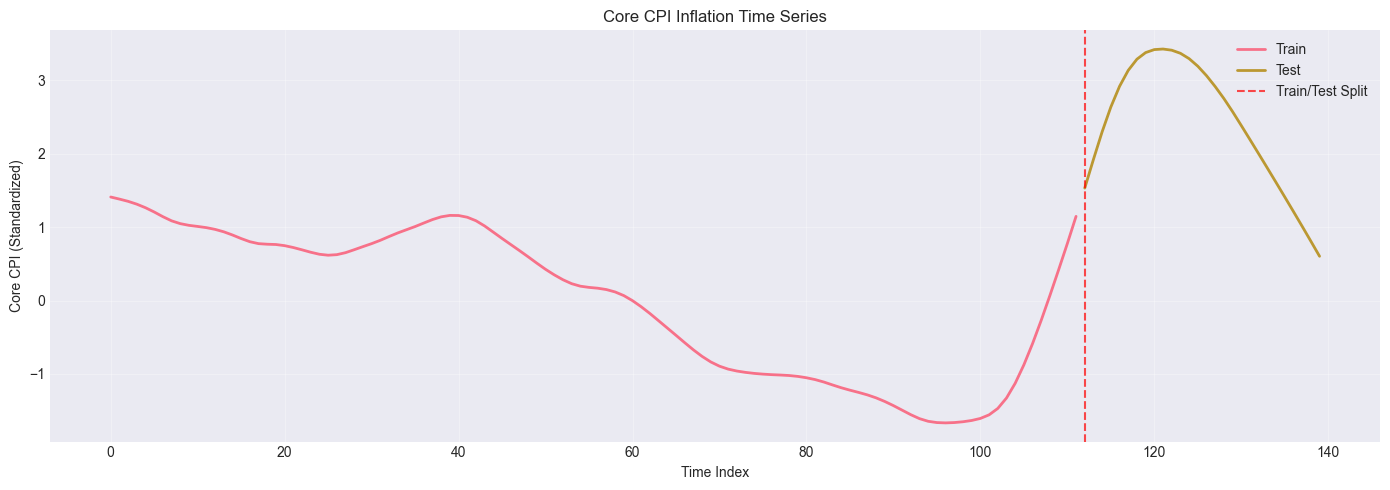

In [6]:
# Load processed data
train_df = pd.read_csv('../data/processed/train_clean.csv')
test_df = pd.read_csv('../data/processed/test_clean.csv')

# Extract target variable (Core CPI)
y_train = train_df['Core CPI'].values
y_test = test_df['Core CPI'].values

print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")
print(f"\nTraining data range: [{y_train.min():.4f}, {y_train.max():.4f}]")
print(f"Test data range: [{y_test.min():.4f}, {y_test.max():.4f}]")

# Visualize the time series
plt.figure(figsize=(14, 5))
plt.plot(range(len(y_train)), y_train, label='Train', linewidth=2)
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test', linewidth=2)
plt.axvline(x=len(y_train), color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
plt.xlabel('Time Index')
plt.ylabel('Core CPI (Standardized)')
plt.title('Core CPI Inflation Time Series')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ADF Test for Core CPI Training Data:
  ADF Statistic: -1.687915
  p-value: 0.437350
  Critical Values:
    1%: -3.499
    5%: -2.892
    10%: -2.583
  => Series is NON-STATIONARY (fail to reject H0)



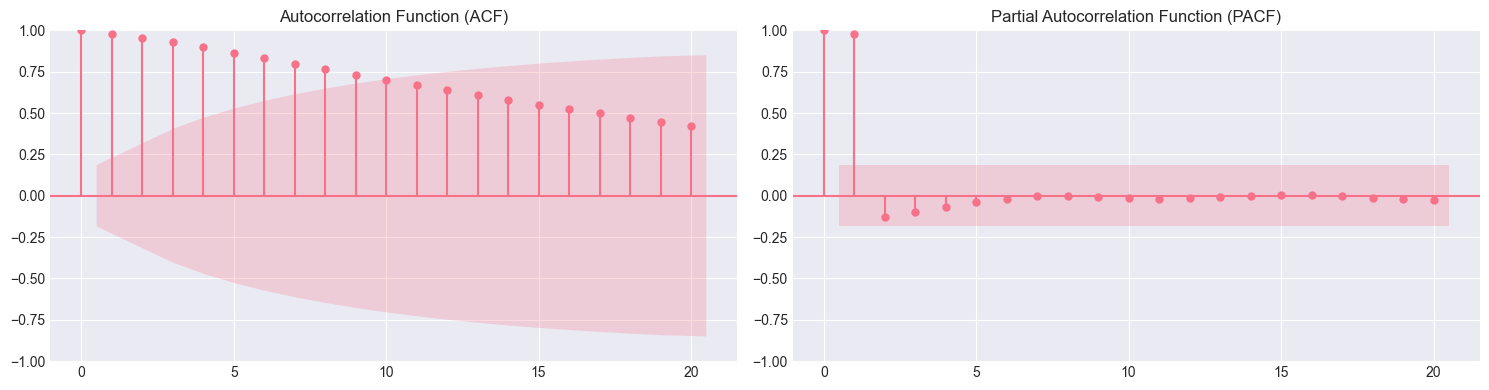

In [7]:
# Stationarity test (Augmented Dickey-Fuller test)
def adf_test(series, name=''):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    result = adfuller(series, autolag='AIC')
    print(f'ADF Test for {name}:')
    print(f'  ADF Statistic: {result[0]:.6f}')
    print(f'  p-value: {result[1]:.6f}')
    print(f'  Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f"  => Series is STATIONARY (reject H0)\n")
        return True
    else:
        print(f"  => Series is NON-STATIONARY (fail to reject H0)\n")
        return False

# Test stationarity
is_stationary = adf_test(y_train, 'Core CPI Training Data')

# Plot ACF and PACF to determine ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(y_train, lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(y_train, lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [8]:
# Grid search for optimal ARIMA parameters
def arima_grid_search(y_train, y_test, p_range, d_range, q_range):
    """
    Perform grid search to find optimal ARIMA parameters
    
    Parameters:
    -----------
    y_train : array-like
        Training data
    y_test : array-like
        Test data
    p_range : range
        Range of AR (p) parameters to test
    d_range : range
        Range of differencing (d) parameters to test
    q_range : range
        Range of MA (q) parameters to test
    
    Returns:
    --------
    results : list
        List of dictionaries with model parameters and metrics
    """
    results = []
    total_combinations = len(p_range) * len(d_range) * len(q_range)
    current = 0
    
    print(f"Testing {total_combinations} ARIMA model combinations...\n")
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                current += 1
                try:
                    # Fit ARIMA model
                    model = ARIMA(y_train, order=(p, d, q))
                    fitted_model = model.fit()
                    
                    # Forecast on test set
                    forecast = fitted_model.forecast(steps=len(y_test))
                    
                    # Calculate metrics
                    rmsfe_score = rmsfe(y_test, forecast)
                    mape_score = mape(y_test, forecast)
                    aic = fitted_model.aic
                    bic = fitted_model.bic
                    
                    results.append({
                        'p': p, 'd': d, 'q': q,
                        'RMSFE': rmsfe_score,
                        'MAPE': mape_score,
                        'AIC': aic,
                        'BIC': bic,
                        'model': fitted_model
                    })
                    
                    print(f"[{current}/{total_combinations}] ARIMA({p},{d},{q}) - "
                          f"RMSFE: {rmsfe_score:.4f}, MAPE: {mape_score:.4f}, "
                          f"AIC: {aic:.2f}, BIC: {bic:.2f}")
                    
                except Exception as e:
                    print(f"[{current}/{total_combinations}] ARIMA({p},{d},{q}) - Failed: {str(e)[:50]}")
                    continue
    
    return results

# Define parameter ranges
p_range = range(0, 4)  # AR order: 0, 1, 2, 3
d_range = range(0, 2)  # Differencing: 0, 1
q_range = range(0, 4)  # MA order: 0, 1, 2, 3

# Perform grid search
results = arima_grid_search(y_train, y_test, p_range, d_range, q_range)

Testing 32 ARIMA model combinations...

[1/32] ARIMA(0,0,0) - RMSFE: 2.5660, MAPE: 100.0003, AIC: 321.84, BIC: 327.28
[2/32] ARIMA(0,0,1) - RMSFE: 2.5436, MAPE: 97.8484, AIC: 175.45, BIC: 183.60
[3/32] ARIMA(0,0,2) - RMSFE: 2.5191, MAPE: 95.6340, AIC: 32.95, BIC: 43.83
[2/32] ARIMA(0,0,1) - RMSFE: 2.5436, MAPE: 97.8484, AIC: 175.45, BIC: 183.60
[3/32] ARIMA(0,0,2) - RMSFE: 2.5191, MAPE: 95.6340, AIC: 32.95, BIC: 43.83
[4/32] ARIMA(0,0,3) - RMSFE: 2.4921, MAPE: 93.4368, AIC: -105.67, BIC: -92.08
[5/32] ARIMA(0,1,0) - RMSFE: 1.5365, MAPE: 51.2672, AIC: -198.38, BIC: -195.67
[6/32] ARIMA(0,1,1) - RMSFE: 1.3856, MAPE: 47.5158, AIC: -337.68, BIC: -332.26
[7/32] ARIMA(0,1,2) - RMSFE: 1.2443, MAPE: 44.9284, AIC: -470.92, BIC: -462.79
[4/32] ARIMA(0,0,3) - RMSFE: 2.4921, MAPE: 93.4368, AIC: -105.67, BIC: -92.08
[5/32] ARIMA(0,1,0) - RMSFE: 1.5365, MAPE: 51.2672, AIC: -198.38, BIC: -195.67
[6/32] ARIMA(0,1,1) - RMSFE: 1.3856, MAPE: 47.5158, AIC: -337.68, BIC: -332.26
[7/32] ARIMA(0,1,2) - RMSFE

In [9]:
# Create results dataframe and find best model
if len(results) > 0:
    results_df = pd.DataFrame(results)
    results_df = results_df.drop('model', axis=1).sort_values('RMSFE')
    
    print("\n" + "="*70)
    print("TOP 10 MODELS BY RMSFE")
    print("="*70)
    print(results_df.head(10).to_string(index=False))
    
    print("\n" + "="*70)
    print("TOP 10 MODELS BY MAPE")
    print("="*70)
    print(results_df.sort_values('MAPE').head(10).to_string(index=False))
    
    print("\n" + "="*70)
    print("TOP 10 MODELS BY AIC")
    print("="*70)
    print(results_df.sort_values('AIC').head(10).to_string(index=False))
    
    # Get best model by RMSFE
    best_result = min(results, key=lambda x: x['RMSFE'])
    best_model = best_result['model']
    best_order = (best_result['p'], best_result['d'], best_result['q'])
    
    print(f"\n{'='*70}")
    print(f"BEST MODEL: ARIMA{best_order}")
    print(f"{'='*70}")
    print(f"RMSFE: {best_result['RMSFE']:.6f}")
    print(f"MAPE:  {best_result['MAPE']:.6f}")
    print(f"AIC:   {best_result['AIC']:.6f}")
    print(f"BIC:   {best_result['BIC']:.6f}")
else:
    print("No models were successfully fitted!")


TOP 10 MODELS BY RMSFE
 p  d  q    RMSFE      MAPE         AIC         BIC
 2  1  0 0.698882 30.330963 -799.834102 -791.705511
 3  0  0 0.761614 41.926336 -791.542460 -777.949966
 0  1  3 1.109152 43.306598 -596.656292 -585.818172
 1  0  3 1.112230 43.152723 -590.156539 -573.845546
 2  0  3 1.240662 44.865321 -454.031457 -435.001965
 0  1  2 1.244319 44.928370 -470.917440 -462.788849
 1  0  2 1.255999 44.719588 -464.852165 -451.259671
 0  1  1 1.385565 47.515761 -337.679976 -332.260916
 1  0  1 1.398464 47.530009 -331.713967 -320.839972
 3  0  3 1.428844 48.495719 -266.165587 -244.417596

TOP 10 MODELS BY MAPE
 p  d  q    RMSFE      MAPE         AIC         BIC
 2  1  0 0.698882 30.330963 -799.834102 -791.705511
 3  0  0 0.761614 41.926336 -791.542460 -777.949966
 1  0  3 1.112230 43.152723 -590.156539 -573.845546
 0  1  3 1.109152 43.306598 -596.656292 -585.818172
 1  0  2 1.255999 44.719588 -464.852165 -451.259671
 2  0  3 1.240662 44.865321 -454.031457 -435.001965
 0  1  2 1.244319

Final Model Evaluation on Test Set:
  ARIMA(2, 1, 0)
  RMSFE: 0.698882
  MAPE:  30.330963


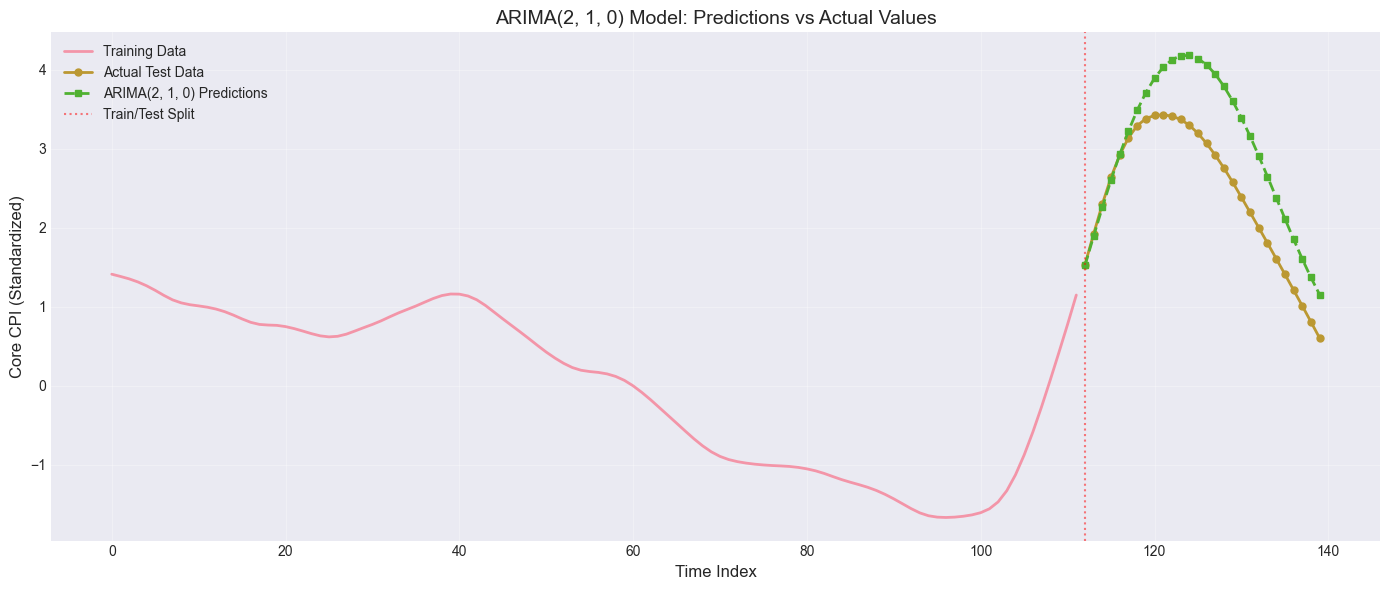

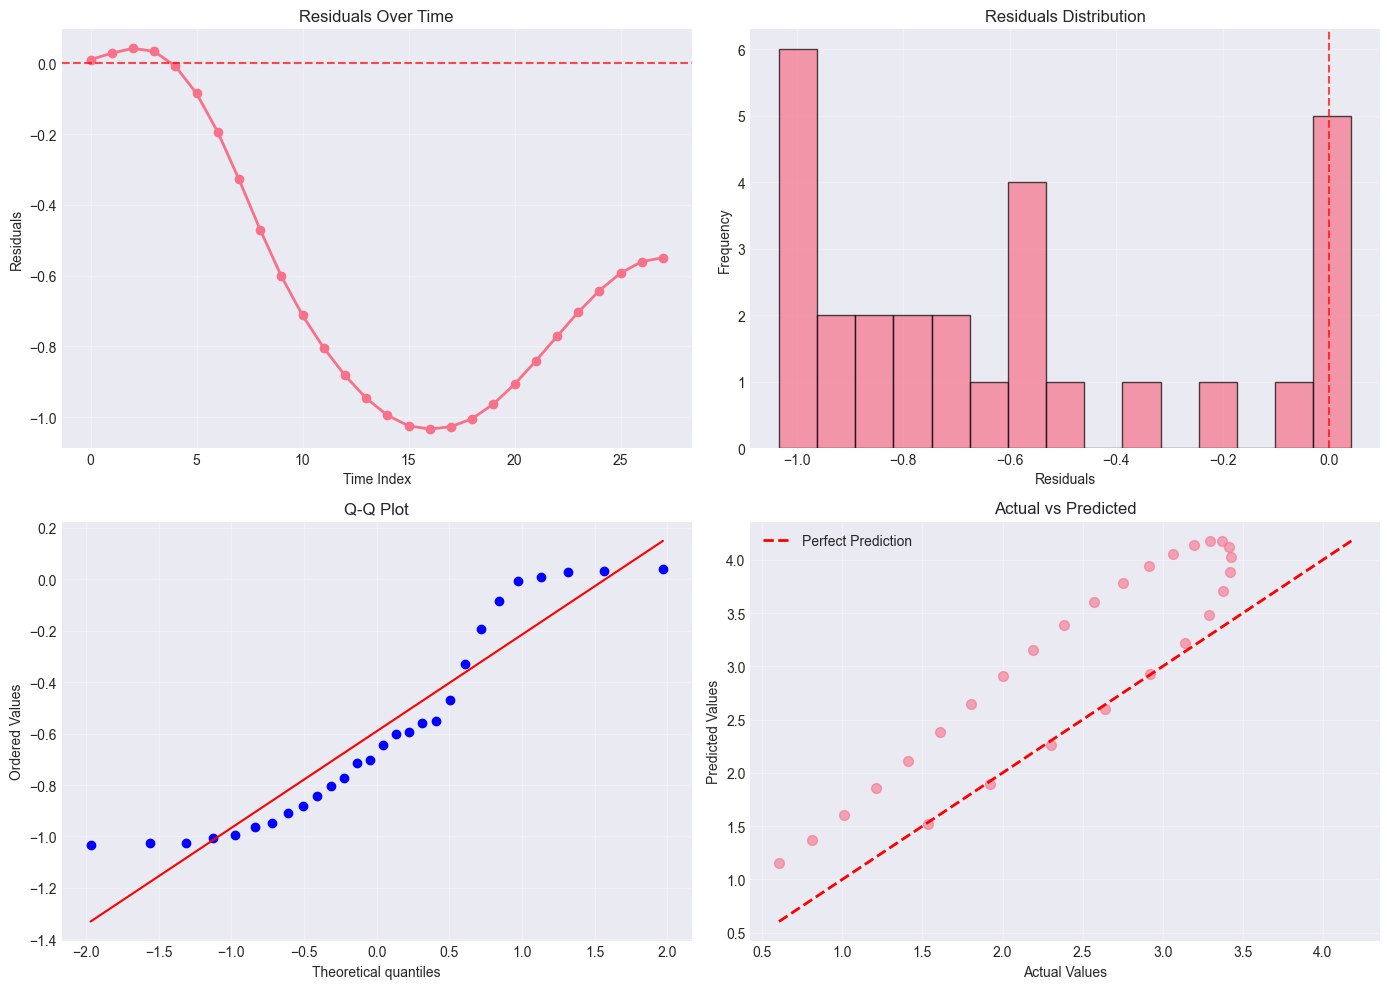


Residuals Summary Statistics:
  Mean:     -0.590662
  Std Dev:  0.373570
  Min:      -1.033976
  Max:      0.042228
  Median:   -0.673286


In [10]:
# Generate predictions with best model
if len(results) > 0:
    # Forecast on test set
    y_pred = best_model.forecast(steps=len(y_test))
    
    # Calculate final metrics
    final_rmsfe = rmsfe(y_test, y_pred)
    final_mape = mape(y_test, y_pred)
    
    print(f"Final Model Evaluation on Test Set:")
    print(f"  ARIMA{best_order}")
    print(f"  RMSFE: {final_rmsfe:.6f}")
    print(f"  MAPE:  {final_mape:.6f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(14, 6))
    
    # Plot training data
    plt.plot(range(len(y_train)), y_train, label='Training Data', 
             linewidth=2, alpha=0.7)
    
    # Plot test data
    test_indices = range(len(y_train), len(y_train) + len(y_test))
    plt.plot(test_indices, y_test, label='Actual Test Data', 
             linewidth=2, marker='o', markersize=5)
    
    # Plot predictions
    plt.plot(test_indices, y_pred, label=f'ARIMA{best_order} Predictions', 
             linewidth=2, linestyle='--', marker='s', markersize=5)
    
    plt.axvline(x=len(y_train), color='red', linestyle=':', 
                alpha=0.5, label='Train/Test Split')
    plt.xlabel('Time Index', fontsize=12)
    plt.ylabel('Core CPI (Standardized)', fontsize=12)
    plt.title(f'ARIMA{best_order} Model: Predictions vs Actual Values', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../results/figures/arima_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot residuals
    residuals = y_test - y_pred
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Residuals over time
    axes[0, 0].plot(residuals, marker='o', linewidth=2)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_title('Residuals Over Time')
    axes[0, 0].set_xlabel('Time Index')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Residuals histogram
    axes[0, 1].hist(residuals, bins=15, edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].set_title('Residuals Distribution')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Q-Q plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Actual vs Predicted scatter
    axes[1, 1].scatter(y_test, y_pred, alpha=0.6, s=50)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 
                    'r--', linewidth=2, label='Perfect Prediction')
    axes[1, 1].set_xlabel('Actual Values')
    axes[1, 1].set_ylabel('Predicted Values')
    axes[1, 1].set_title('Actual vs Predicted')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/figures/arima_diagnostics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics of residuals
    print("\nResiduals Summary Statistics:")
    print(f"  Mean:     {residuals.mean():.6f}")
    print(f"  Std Dev:  {residuals.std():.6f}")
    print(f"  Min:      {residuals.min():.6f}")
    print(f"  Max:      {residuals.max():.6f}")
    print(f"  Median:   {np.median(residuals):.6f}")
else:
    print("No model available for evaluation!")

In [11]:
# Save results
if len(results) > 0:
    # Save predictions
    predictions_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Residual': residuals
    })
    predictions_df.to_csv('../results/tables/arima_predictions.csv', index=False)
    print("✓ Predictions saved to: ../results/tables/arima_predictions.csv")
    
    # Save grid search results
    results_df.to_csv('../results/tables/arima_grid_search.csv', index=False)
    print("✓ Grid search results saved to: ../results/tables/arima_grid_search.csv")
    
    # Save metrics summary
    metrics_summary = pd.DataFrame({
        'Model': [f'ARIMA{best_order}'],
        'RMSFE': [final_rmsfe],
        'MAPE': [final_mape],
        'AIC': [best_result['AIC']],
        'BIC': [best_result['BIC']],
        'Parameters': [f"p={best_order[0]}, d={best_order[1]}, q={best_order[2]}"]
    })
    metrics_summary.to_csv('../results/tables/arima_metrics.csv', index=False)
    print("✓ Metrics summary saved to: ../results/tables/arima_metrics.csv")
    
    # Print summary
    print("\n" + "="*70)
    print("ARIMA MODEL SUMMARY")
    print("="*70)
    print(metrics_summary.to_string(index=False))
    print("="*70)
    
    print("\n✅ ARIMA model training and evaluation completed successfully!")
else:
    print("❌ No results to save!")

✓ Predictions saved to: ../results/tables/arima_predictions.csv
✓ Grid search results saved to: ../results/tables/arima_grid_search.csv
✓ Metrics summary saved to: ../results/tables/arima_metrics.csv

ARIMA MODEL SUMMARY
         Model    RMSFE      MAPE         AIC         BIC    Parameters
ARIMA(2, 1, 0) 0.698882 30.330963 -799.834102 -791.705511 p=2, d=1, q=0

✅ ARIMA model training and evaluation completed successfully!
